# Demonstrating batch acquisition

In [2]:
def get_ds(args):
    """
    Gets data from disk and applies train/test split.
    """
    ds = getattr(pinot.data, args['data'])()
    partition = [int(a) for a in args['partition'].split(':')]
    ds_tr, ds_te = pinot.data.utils.split(ds, partition)
    return ds_tr, ds_te

def get_gpr(args):
    layer = pinot.representation.dgl_legacy.gn(model_name=args['layer'])

    net_representation = pinot.representation.Sequential(
        layer=layer,
        config=args['config'])

    kernel = pinot.inference.gp.kernels.deep_kernel.DeepKernel(
            representation=net_representation,
            base_kernel=pinot.inference.gp.kernels.rbf.RBF())

    gpr = pinot.inference.gp.gpr.exact_gpr.ExactGPR(
            kernel)
    return gpr

In [3]:
args = {'layer': 'GraphConv',
 'noise_model': 'normal-heteroschedastic',
 'optimizer': 'adam',
 'config': [32, 'tanh', 32, 'tanh', 32, 'tanh'],
 'out': 'result',
 'data': 'esol',
 'batch_size': 32,
 'opt': 'Adam',
 'lr': 1e-03,
 'partition': '4:1',
 'n_epochs': 40}

In [4]:
from torch import nn
from copy import deepcopy
from botorch.posteriors import Posterior
from botorch.posteriors.gpytorch import GPyTorchPosterior
from botorch.models.model import Model
from gpytorch.distributions import MultivariateNormal
from torch import Tensor

class BTModel(nn.Module):
    r"""Wrapping the pinot gpr model for BoTorch."""
    
    def __init__(self, gpr):
        super(BTModel, self).__init__()
        self.gpr = gpr
        self.num_outputs = 1 # needs to be 1 for most of these functions

    def condition(self, X: Tensor) -> Posterior:
        r"""Computes the posterior over model outputs at the provided points.

        Args:
            X: A `b x q x d`-dim Tensor, where `d` is the dimension of the
                feature space, `q` is the number of points considered jointly,
                and `b` is the batch dimension.
            output_indices: A list of indices, corresponding to the outputs over
                which to compute the posterior (if the model is multi-output).
                Can be used to speed up computation if only a subset of the
                model's outputs are required for optimization. If omitted,
                computes the posterior over all model outputs.
            observation_noise: If True, add observation noise to the posterior.

        Returns:
            A `Posterior` object, representing a batch of `b` joint distributions
            over `q` points and `m` outputs each.
        """
        self.gpr.eval()
        out = self.gpr.condition(X)
        gptorch_mvn = MultivariateNormal(out.mean, out.covariance_matrix)
        return GPyTorchPosterior(gptorch_mvn)
    
    def loss(self, g, y):
        return self.gpr.loss(g, y)

In [10]:
import torch
import sys

# sys.path.append('../pinot/')

import pinot
from pinot.active import experiment

net = BTModel(get_gpr(args))
ds = getattr(pinot.data, args['data'])()
ds = pinot.data.utils.batch(ds, len(ds), seed=None)

bo = pinot.active.experiment.SingleTaskBayesianOptimizationExperiment(
            net=net,
            data=ds[0],
            optimizer=torch.optim.Adam(net.parameters(), 1e-3),
            acquisition=pinot.active.acquisition.monte_carlo_acq,
            q=1,
            n_epochs_training=10,
            slice_fn = experiment._slice_fn_tuple,
            collate_fn = experiment._collate_fn_graph
)

In [11]:
x = bo.run(limit=60)

In [12]:
import numpy as np
gs, ys = ds[0]
best_sol_seq = np.maximum.accumulate(ys[x])

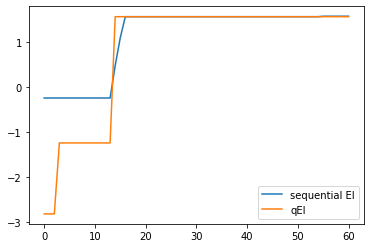

In [13]:
import matplotlib.pyplot as plt

plt.plot(best_sol_seq, label='sequential EI')
plt.plot(best_sol, label='qEI')
plt.legend()